In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.special import cotdg
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from gzbuilderspirals.oo import Pipeline, Arm
from gzbuilderspirals import xy_from_r_theta
import lib.galaxy_utilities as gu

In [3]:
mangaid = '8247-12703'
subject_id = 21096811

In [12]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array, _ = gu.get_image(gal, subject_id, angle)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [10]:
scale = 4 * float(gal['PETRO_THETA'])
imshow_kwargs = {
    'cmap': 'gray',
    'origin': 'lower',
    'extent': [-0.5 * scale, 0.5 * scale] * 2,
}

In [5]:
p = Pipeline.load('lib/pipelines/{}.json'.format(subject_id))
arms_files = [
    i for i in os.listdir('lib/spiral_arms') if str(subject_id) in i
]
arms = [
    Arm.load('lib/spiral_arms/{}'.format(a))
    for a in arms_files
]

In [51]:
def theta_from_pa(r, pa, a=0):
    # r = exp(a + tan(pa) * theta)
    return (np.log(r) - a) * cotdg(pa)


def fit_a(pa, R, T):
    def __distance_func(p):
        t = theta_from_pa(R, pa, p[0])
        return np.abs(T - t).sum()
    return minimize(__distance_func, (0,))


def fit_varying_pa(arm, r, pa):
    # interpolate pa(r)
    pa_wrt_r = interp1d(
        r, pa,
        bounds_error=False,
        fill_value='extrapolate'
    )
    a = fit_a(
        pa_wrt_r(arm.R),
        arm.R,
        arm.t,
    )['x'][0]
    print(a)
    R = np.linspace(min(arm.R), max(arm.R), 100)
    print(min(arm.R), max(arm.R))
    print(min(pa_wrt_r(R)), max(pa_wrt_r(R)))
    plt.figure()
#     plt.plot(r, pa, '.')
#     plt.plot(R, pa_wrt_r(R))
    t = theta_from_pa(R, pa_wrt_r(R), a)
    plt.plot(R, np.tan(np.deg2rad(pa_wrt_r(R))))
#     varying_r = np.exp(
#         a + np.tan(
#             np.deg2rad(pa_wrt_t(arm.t_predict))
#         ) * arm.t_predict
#     )
    return np.array(
        xy_from_r_theta(
            R,
            t,
        )
    ).T

1.8452129247884244
0.040181577650311766 0.24545379639848938
29.495880155936 51.62634683251678


(-0.03791494174048884,
 0.22267006222476726,
 -0.07703264320076121,
 0.13545808382955027)

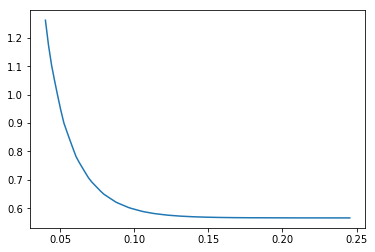

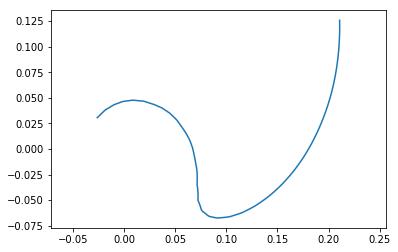

In [52]:
arm = arms[0]
varying_arm = fit_varying_pa(
    arm, zoo_coords_r, sa_pa,
)
plt.figure()
plt.plot(*varying_arm.T)
plt.axis('equal')

In [7]:
zoo_coords_r, sa_pa = np.load('pavr.npy').T

2 arms
-0.4573721693889415
0.040181577650311766 0.24545379639848938
29.495880155936 51.62634683251678
-2.640655699489171
0.04715515054168284 0.12228802922640894
29.92303183712599 45.826097395789816


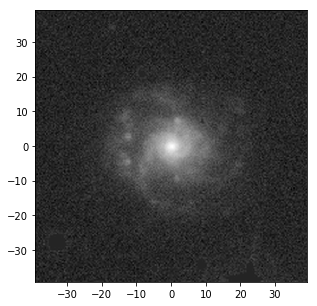

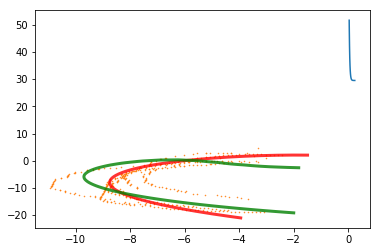

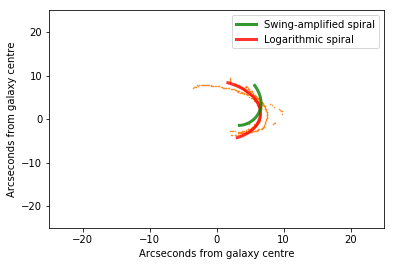

In [34]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
print(len(arms), 'arms')
plt.imshow(pic_array, **imshow_kwargs)
for i, arm in enumerate(arms):
    varying_arm = fit_varying_pa(
        arm, zoo_coords_r, sa_pa,
    )
    plt.plot(*arm.deprojected_coords.T * scale, '.', markersize=1,
             alpha=1)
    plt.plot(*(arm.log_spiral.T / arm.image_size - 0.5)*scale, c='r',
             linewidth=3, alpha=0.8)
    plt.plot(*varying_arm.T * scale, c='g',
             linewidth=3, alpha=0.8)
# plots for legend
plt.plot([], [], c='g', linewidth=3, alpha=0.8,
         label='Swing-amplified spiral')
plt.plot([], [], c='r', linewidth=3, alpha=0.8,
         label='Logarithmic spiral')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
# plt.axis('equal')
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.legend()